# Plot Magnetic Sensor Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
#sns.set(sytle="darkgrid")
import math

---
Modified  By    Reason
01-Jan-22 CBL   Original
04-Jan-22 CBL   Continued investigations. Added in the ability to add latex and greek characters in markdown cells. 
                looking to add SciPy functionality. 
----
<!-- Enable the use of Latex in the markdown comments. -->
<!-- Got this from: http://flennerhag.com/2017-01-14-latex/ -->
<script type="text/javascript"
        src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.0/MathJax.js?config=TeX-AMS_CHTML"></script>
<!-- ![image.info](./Sphere.png) -->
<img src="Sphere.png" alt="Spherical Coordinates" width="200"/>
The image above shows the spherical coordinate system used in this document. \\(\theta\\) is the x-y plane and uses right hand rule for x into y with z up. \\(\Phi\\) is the rotation angle around X. When we rotate coordinate systems we will use the conventions shown in the figure above.
<img src="FS7OG.png" alt="RPH definitions." width="200"/>
This image shows the Roll, Pitch and Yaw definitions for the same set of axes. For these I will use the convention 
of \\(\alpha\\), \\(\beta\\), and \\(\gamma\\) as the rotation angles around X, Y and Z for standard rotation matricies. 

In [5]:
# Import the CSV using pandas
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# In the file provided there are 1002 lines by 13 columns. 
# The data is organized by the way the names are assigned. 
#df = pd.read_csv("Mag2.CSV",names=['Index','Time','GX','GY','GZ','AX','AY','AZ','MX','MY','MZ','H','R','P'])
# Or I can format the file with Row 0 containing the names comma delimited and use a simpler read. 
# This data was taken using a 9DOF sensor from Sparkfun into an Arduino. 
# The sensor was slowly rotated several times. 
df = pd.read_csv("Mag2.CSV",dtype={'Index':np.int32,'Time':np.float64,
                                   'GX':np.float64,'GY':np.float64,'GZ':np.float64,
                                   'AZ':np.float64,'AY':np.float64,'AZ':np.float64,
                                   'MX':np.float64,'MY':np.float64,'MZ':np.float64,
                                   'H':np.float64,'R':np.float64,'P':np.float64})

# The data is now in a DataFrame (df)
# Print out some of the information about the data frame. 
#
print('Mag2.CSV data format:', df.shape )
print(df.columns)
# Access the data
# This gives a vector of time only 
t = df['Index']
#print(t)
# Normalize the time from t0
t = t - t[0]
#
# Use Later, a way to slice the data. 
#
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
#


Mag2.CSV data format: (1000, 14)
Index(['Index', 'Time', 'GX', 'GY', 'GZ', 'AX', 'AY', 'AZ', 'MX', 'MY', 'MZ',
       'H', 'R', 'P'],
      dtype='object')


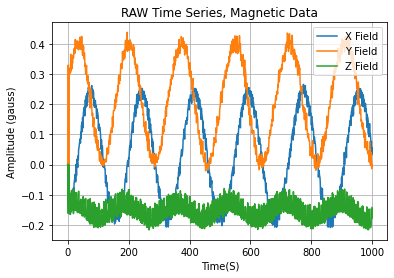

In [6]:
Mx = df['MX']     # Magnetic field X only
My = df['MY']
Mz = df['MZ']
H  = df['H']
plt.plot(t,Mx,label='X Field')
plt.plot(t,My,label='Y Field')
plt.plot(t,Mz,label='Z Field')
#
# Add Axis markers. 
#
plt.title("RAW Time Series, Magnetic Data")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude (gauss)")
#
# Grid on (also shows other projections) https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
plt.grid()
plt.legend()
plt.show()

Considering that this represents a sensor that is turned in a circle it should be surmized that the 
value of the fields should be in a rotationally symmetric frame of reference and be 90 degrees out of 
phase (assuming that the sensors are truely orthogonal. 
This makes me believe that the sensors have a bias. 
Looking down at the data below and revisiting this conjecture, this could be a frame change. The combination of angular offsets in \\(\alpha\\) , \\(\beta\\) and \\(\gamma\\) could account for this.
Next, Look at the overall magnitude of the magnetic field. 

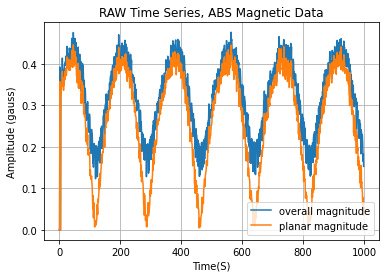

In [12]:
magxy2 = Mx*Mx + My*My
mag = np.sqrt(magxy2 + Mz*Mz)
plt.plot(t,mag,label='overall magnitude')
plt.plot(t,np.sqrt(magxy2), label='planar magnitude')
#
# Add Axis markers. 
#
plt.title("RAW Time Series, ABS Magnetic Data")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude (gauss)")
#
# Grid on (also shows other projections) https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
plt.grid()
plt.legend()
plt.show()
#
# 1G = 10^5nT
# the earth field should be between 25,000 - 65,000 nT
# This seems about right
#


What I can see from this plot is that there is an angle that contributes to the Z value, which should be constant.
This is seen by the deep nulls in the absolute magnitude of (MX+MY). It should be symmetric and just slightly
smaller than the overall magnitude. 

Mx, My and Mz are all relative to the axis of the sensor. The projecton of the magnitude onto Z 

This implies that Phi is non-zero. The question is how to calculate what Phi is? We can try to use values of Phi to determine what the angle is with the minimization function being to get the planar magnitude closer to a sine wave 
and the projection onto Mz a single value function. 


Minval: 1.9385386170729122  at: 72.10142985756245


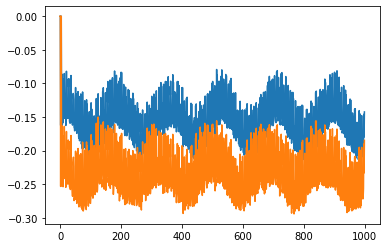

In [30]:
# Find the angle Phi that minimizes the variation on Mz. 
min = 10.0
minang = np.pi
for Phi in np.arange(-np.pi,np.pi,0.1):
    Mzp = mag*np.cos(Phi) - np.sqrt(magxy2)*np.sin(Phi)
    dMz = (Mz-Mzp)
    val = np.sum(dMz)
    if (abs(val)<min):
        min = abs(val)
        minang = Phi
#
# The projection will match when we rotate to the proper value. 
#
#minang = minang - np.pi/2
print ('Minval:', min, " at:", np.rad2deg(minang))
Mzp = mag*np.cos(minang) - np.sqrt(magxy2)*np.sin(Phi)
dMz = (Mz-Mzp)
#plt.plot(t,mag)
plt.plot(t,Mz)
plt.plot(t,dMz)
#print(np.sum(Mz))
# This is a total bust. 

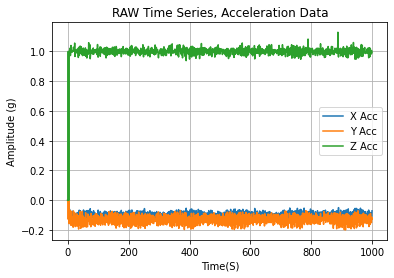

In [7]:
# Lets look at the acceleration data. 
Ax = df['AX']     # Magnetic field X only
Ay = df['AY']
Az = df['AZ']
plt.plot(t,Ax,label='X Acc')
plt.plot(t,Ay,label='Y Acc')
plt.plot(t,Az,label='Z Acc')
#
# Add Axis markers. 
#
plt.title("RAW Time Series, Acceleration Data")
plt.xlabel("Time(S)")
plt.ylabel("Amplitude (g)")
#
# Grid on (also shows other projections) https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
plt.grid()
plt.legend()
plt.show()


Mean Phi= 9.45756308479826


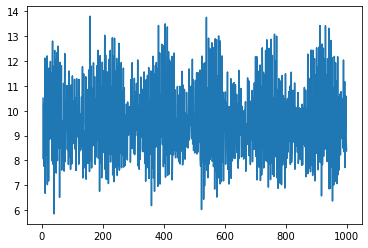

In [11]:
# We should be able to see the Phi angle in the accleration data. 
A_Mag = np.sqrt(Ax*Ax+Ay*Ay+Az*Az)
A_Phi = np.arccos(Az/A_Mag)
Phi_mean = A_Phi.mean()
print("Mean Phi=", np.rad2deg(Phi_mean))
plt.plot(t,np.rad2deg(A_Phi))

This looks like the right value for the tilt. It is difficult to see the dependency on the rotation around z. I would expect to see some since the Phi angle will be oriented at one specific direction. This can be better seen in the magnetic data. 

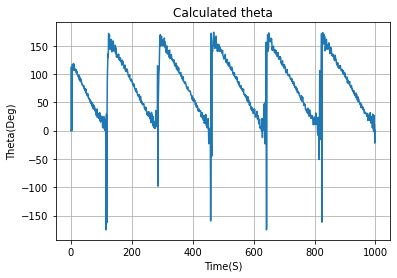

In [7]:
# Calculate heading
#
theta = np.arctan2(My,Mx)   # This is the cartesian angle, arctan2 result is -pi to pi
# convert to degrees
TD = np.rad2deg(theta)
plt.plot(t,TD)
plt.title("Calculated theta")
plt.xlabel("Time(S)")
plt.ylabel("Theta(Deg)")
plt.grid()
plt.show()

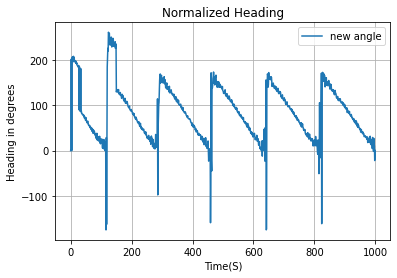

In [16]:
# atan2 only works -pi to pi.
# Work on getting theta to go through 360 degrees first, worry about heading later. 
thetaP = np.copy(theta)
for i in range(0,150):
    if (Mx[i]<0 and My[i]>0):
        thetaP[i] = math.pi/2 + theta[i]
    else:
        thetaP[i] = theta[i]

    #print(i," ",H[i]," ",HP[i]," ", Mx[i], " ", My[i])
# np.unwrap() use later
plt.plot(t,np.rad2deg(thetaP), label='new angle')
#plt.plot(t,TD, label='angle')
plt.title("Normalized Heading")
plt.xlabel("Time(S)")
plt.ylabel("Heading in degrees")
plt.grid()
plt.legend()
plt.show()